# M2D-CLAP Example -- Visualizing Audio Embeddings of ESC-50 Samples

We show an example of audio tagging using a [M2D-CLAP (2025)](https://github.com/nttcslab/m2d/tree/master/clap)  model.
M2D-CLAP provides two types of audio embeddings.
- Conventional audio embeddings -- for conventional transfer learning uses such as fine-tuning.
- CLAP audio embeddings -- for ZS inference.

In [1]:
# The code depends on these external modules.
! pip install timm einops nnAudio librosa >& /dev/null

import warnings; warnings.simplefilter('ignore')
import logging; logging.basicConfig(level=logging.INFO)
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import zipfile
import librosa


In [2]:
# Downloads the ESC-50 dataset.
! git clone https://github.com/karolpiczak/ESC-50.git

meta = pd.read_csv('ESC-50/meta/esc50.csv')
classes = meta.category.unique().tolist()
classes[:5]

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 27.44 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.


['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock']

## Download M2D
- portable_m2d.py -- Portable loader, no dependance on other files from M2D repository.
- m2d_clap_vit_base-80x608p16x16-240128.zip -- M2D-CLAP pre-trained weight.

In [3]:
! wget https://raw.githubusercontent.com/nttcslab/m2d/master/examples/portable_m2d.py
! wget https://github.com/nttcslab/m2d/releases/download/v0.5.0/m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025.zip

with zipfile.ZipFile("m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025.zip", "r") as zip_ref:
    zip_ref.extractall(".")
! find m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025 -name *.pth

--2025-09-20 09:57:26--  https://raw.githubusercontent.com/nttcslab/m2d/master/examples/portable_m2d.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23966 (23K) [text/plain]
Saving to: ‘portable_m2d.py’

portable_m2d.py     100%[===================>]  23.40K  --.-KB/s    in 0.002s  

2025-09-20 09:57:26 (14.8 MB/s) - ‘portable_m2d.py’ saved [23966/23966]

--2025-09-20 09:57:27--  https://github.com/nttcslab/m2d/releases/download/v0.5.0/m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/589370928/9f7bcda1

## Create model


In [4]:
from portable_m2d import PortableM2D
model = PortableM2D(weight_file='m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth')
model.eval(); model.cuda();

 using 166 parameters from m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth
 (included audio_proj params: ['audio_proj.sem_token', 'audio_proj.sem_blocks.0.norm1.weight', 'audio_proj.sem_blocks.0.norm1.bias', 'audio_proj.sem_blocks.0.attn.qkv.weight', 'audio_proj.sem_blocks.0.attn.qkv.bias']
 (included text_proj params: []
 (dropped: [] )
<All keys matched successfully>
 using norm_stats: -7.261779308319092, 4.3511505126953125


## Get embeddings of each sample

In [5]:
# prompt: Get embeddings of all the audios in ESC-50/audio. Then, plot these embeddings in a 2D space using tSNE. Use the corresponding meta.category as the label for each point.

embeddings = []
labels = []
for i in range(len(meta)):
    audio_path = 'ESC-50/audio/' + meta.filename.iloc[i]
    audio, sr = librosa.load(audio_path, sr=model.cfg.sample_rate)
    audio = torch.from_numpy(audio).unsqueeze(0).to('cuda')
    embedding = model(audio)
    embeddings.append(embedding.cpu().detach().numpy())
    labels.append(classes.index(meta.category.iloc[i]))

embeddings = np.concatenate(embeddings)  # 2000 x [1, 32, 3840] -> [2000 samples, 32 time frames, 3840 feature dimensions]
embeddings = embeddings.mean(1)  # -> [2000 samples, 3840 feature dimensions]
embeddings[0]

array([ 0.2403105 , -0.00145232,  0.5426808 , ..., -0.13139921,
        0.24139687, -0.15992619], dtype=float32)

# Conventional audio embeddings

## Plot all 2000 samples

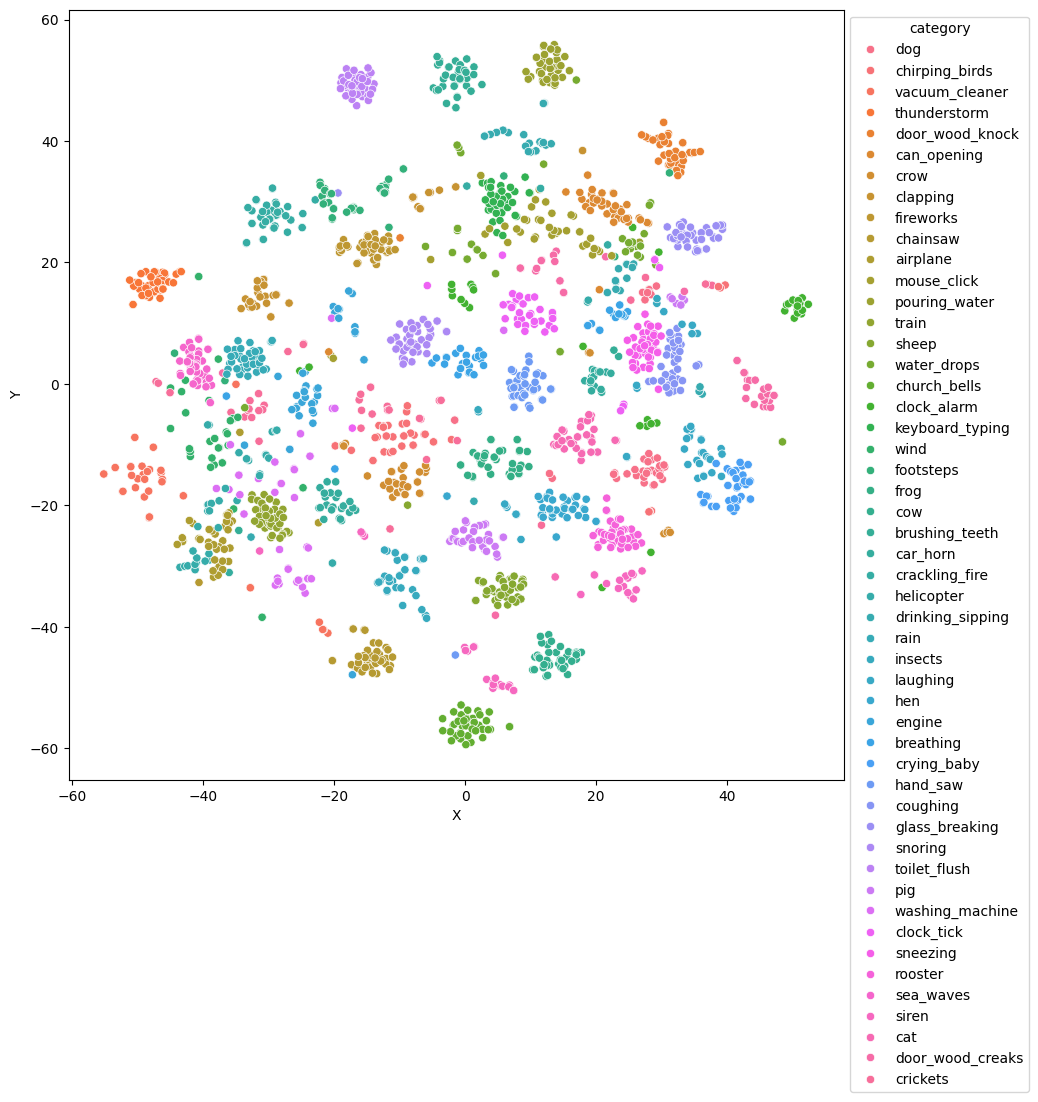

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# TSNE plot
X_embedded = TSNE(n_components=2).fit_transform(embeddings)

meta['X'] = X_embedded[:, 0]
meta['Y'] = X_embedded[:, 1]

# Plot the results
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='X', y='Y', hue='category', data=meta)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Visualize within each sound categories

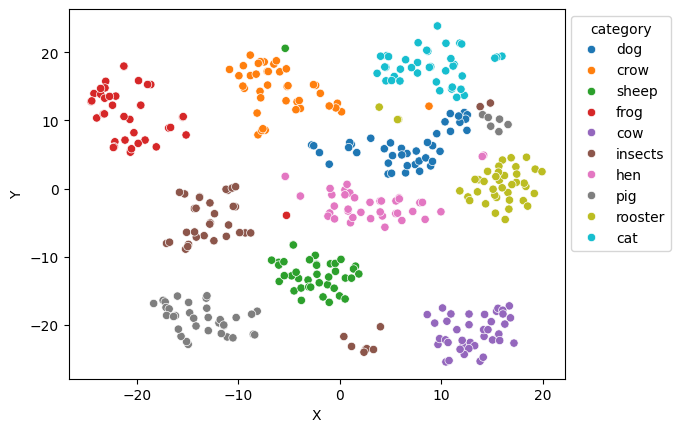

In [7]:
def plot_by_sound_categories(sub_categories):
    m = meta[meta.category.isin(sub_categories)]
    X_embedded = TSNE(n_components=2).fit_transform(embeddings[meta.category.isin(sub_categories)])

    m['X'] = X_embedded[:, 0]
    m['Y'] = X_embedded[:, 1]

    ax = sns.scatterplot(x='X', y='Y', hue='category', data=m)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

sub_categories = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', ]
plot_by_sound_categories(sub_categories)

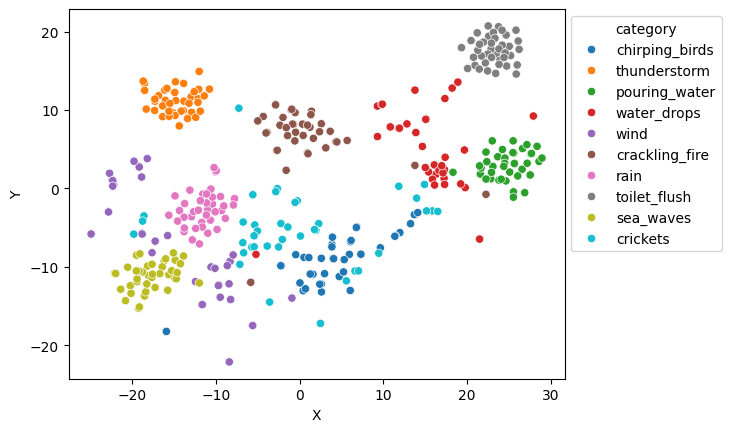

In [8]:
sub_categories = ['rain', 'sea_waves', 'crackling_fire', 'crickets',  'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm',]
plot_by_sound_categories(sub_categories)

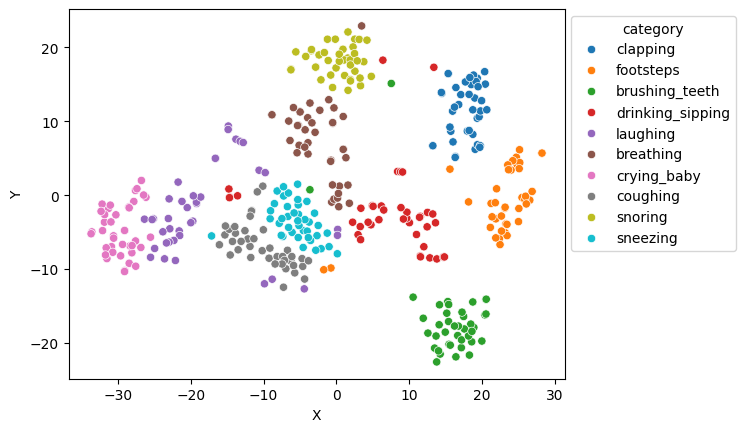

In [9]:
sub_categories = ['crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping',]
plot_by_sound_categories(sub_categories)

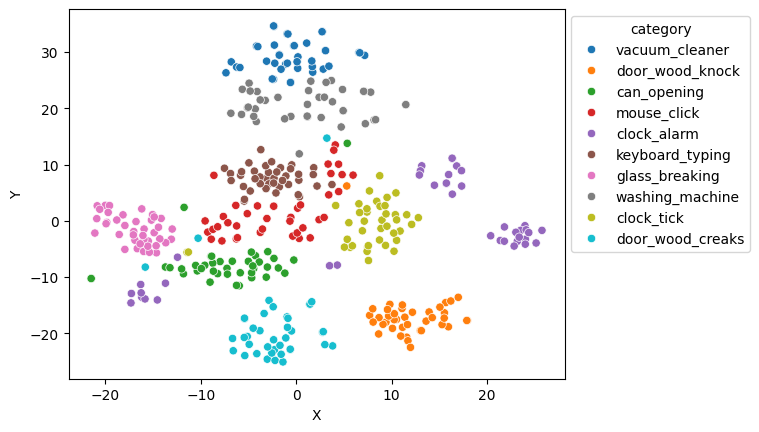

In [10]:
sub_categories = ['door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking',]
plot_by_sound_categories(sub_categories)

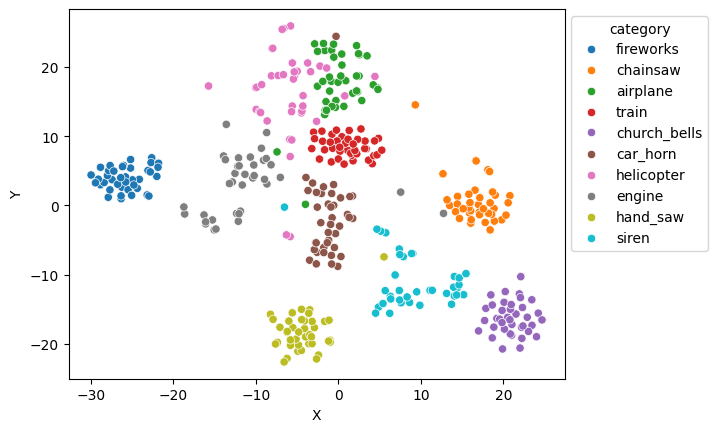

In [11]:
sub_categories = ['helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw', ]
plot_by_sound_categories(sub_categories)

ESC-10 categories ['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain', 'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves']


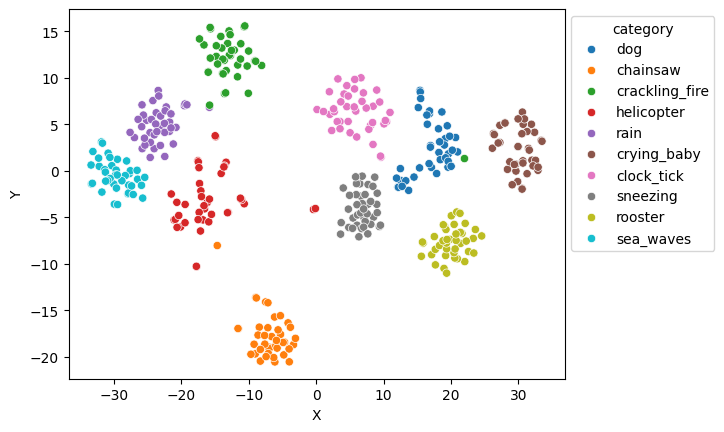

In [12]:
sub_categories = meta[meta.esc10].category.unique()
print('ESC-10 categories', sub_categories.tolist())
plot_by_sound_categories(sub_categories)

# CLAP audio embeddings

In [ ]:
from portable_m2d import PortableM2D
# Use flat_features=True for CLAP features only. For conventional audio features, flat_features should be False.
model = PortableM2D(weight_file='m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth', flat_features=True)
model.eval(); model.cuda();

 using 166 parameters from m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth
 (included audio_proj params: ['audio_proj.sem_token', 'audio_proj.sem_blocks.0.norm1.weight', 'audio_proj.sem_blocks.0.norm1.bias', 'audio_proj.sem_blocks.0.attn.qkv.weight', 'audio_proj.sem_blocks.0.attn.qkv.bias']
 (included text_proj params: []
 (dropped: [] )
<All keys matched successfully>
 using norm_stats: -7.261779308319092, 4.3511505126953125


In [16]:
# prompt: Get embeddings of all the audios in ESC-50/audio. Then, plot these embeddings in a 2D space using tSNE. Use the corresponding meta.category as the label for each point.

embeddings = []
labels = []
for i in range(len(meta)):
    audio_path = 'ESC-50/audio/' + meta.filename.iloc[i]
    audio, sr = librosa.load(audio_path, sr=model.cfg.sample_rate)
    audio = torch.from_numpy(audio).unsqueeze(0).to('cuda')
    embedding = model(audio)
    embedding = model.backbone.audio_proj(embedding)  # to CLAP embeddings
    embeddings.append(embedding.cpu().detach().numpy())
    labels.append(classes.index(meta.category.iloc[i]))

embeddings = np.concatenate(embeddings)  # 2000 x [1, 768] -> [2000 samples, 768 feature dimensions]
embeddings[0][:10]

array([ 0.2781469 ,  0.46780628, -0.63612723,  0.33124653, -0.54939455,
        0.73783463, -0.20069368, -0.5839254 ,  0.7593613 ,  0.39086515],
      dtype=float32)

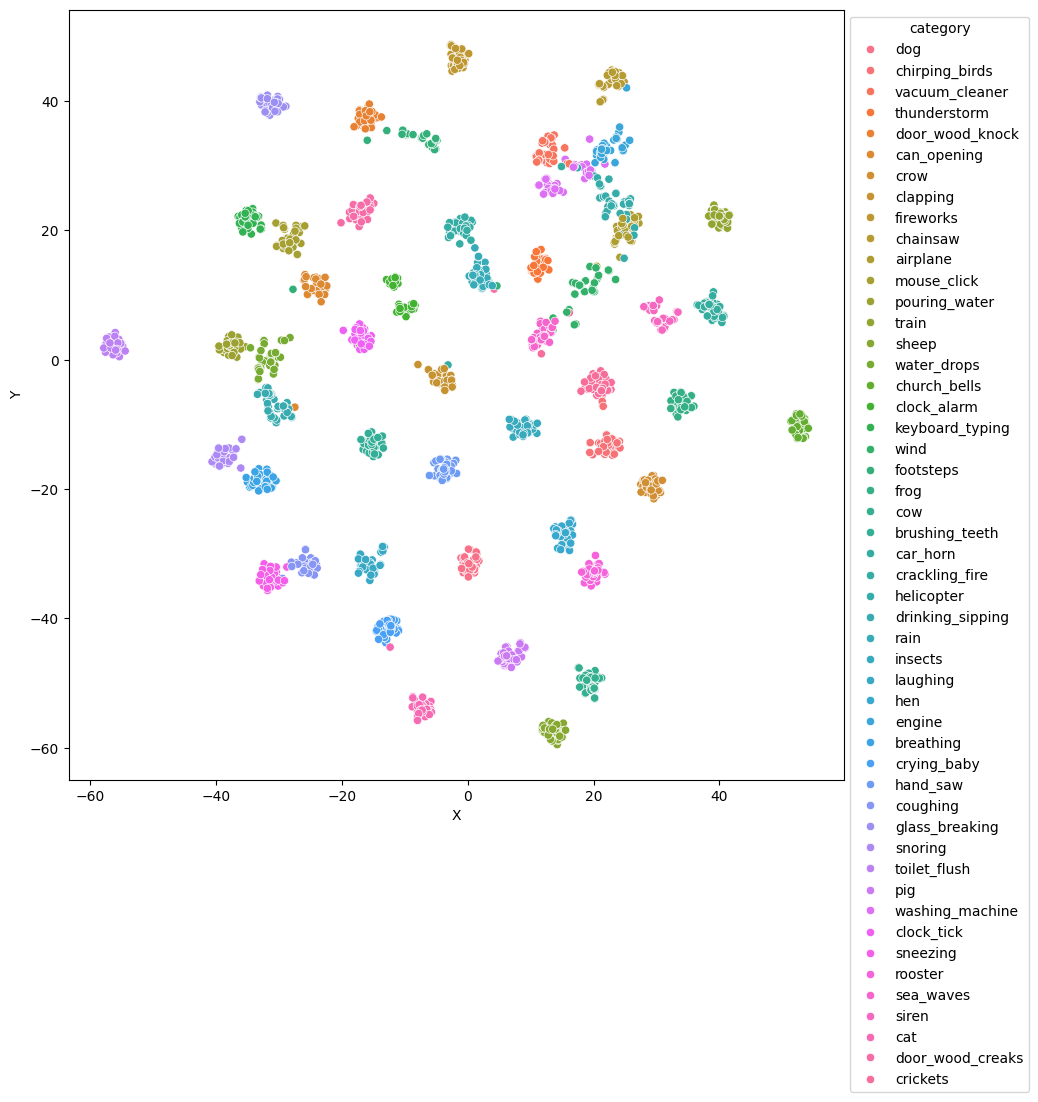

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# TSNE plot
X_embedded = TSNE(n_components=2).fit_transform(embeddings)

meta['X'] = X_embedded[:, 0]
meta['Y'] = X_embedded[:, 1]

# Plot the results
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='X', y='Y', hue='category', data=meta)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Visualize within each sound categories

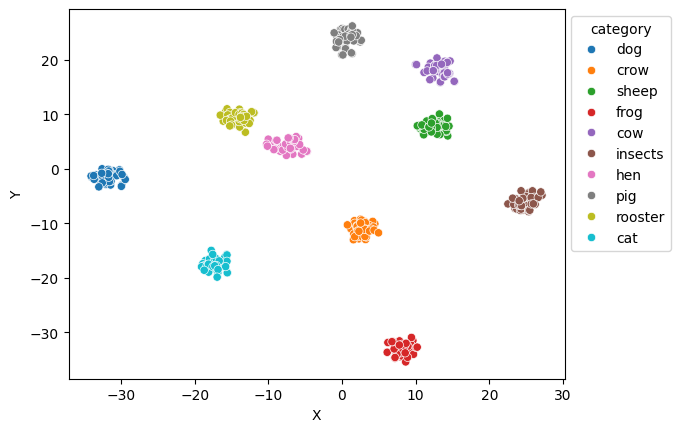

In [18]:
def plot_by_sound_categories(sub_categories):
    m = meta[meta.category.isin(sub_categories)]
    X_embedded = TSNE(n_components=2).fit_transform(embeddings[meta.category.isin(sub_categories)])

    m['X'] = X_embedded[:, 0]
    m['Y'] = X_embedded[:, 1]

    ax = sns.scatterplot(x='X', y='Y', hue='category', data=m)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

sub_categories = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', ]
plot_by_sound_categories(sub_categories)

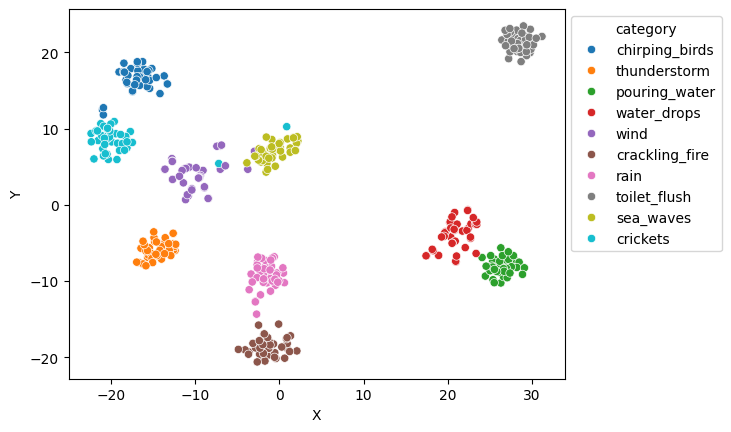

In [19]:
sub_categories = ['rain', 'sea_waves', 'crackling_fire', 'crickets',  'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm',]
plot_by_sound_categories(sub_categories)

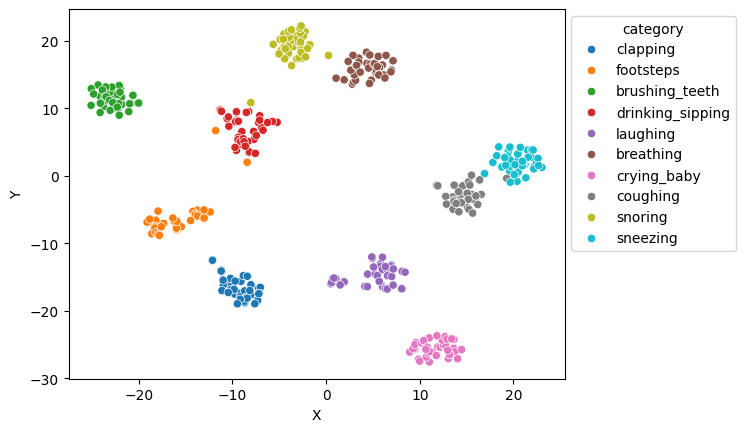

In [20]:
sub_categories = ['crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping',]
plot_by_sound_categories(sub_categories)

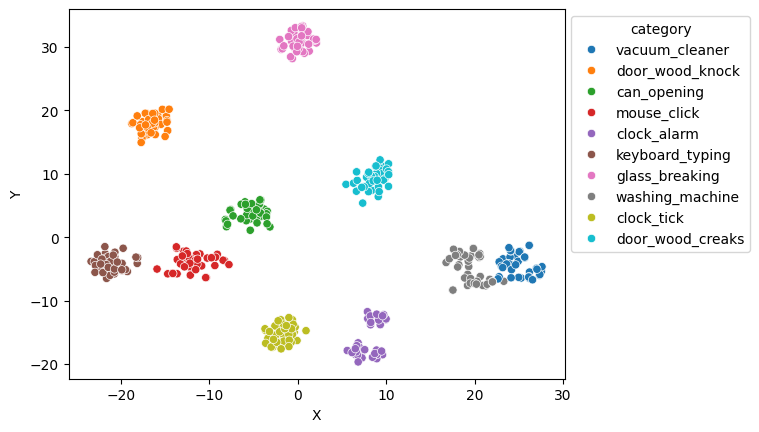

In [21]:
sub_categories = ['door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking',]
plot_by_sound_categories(sub_categories)

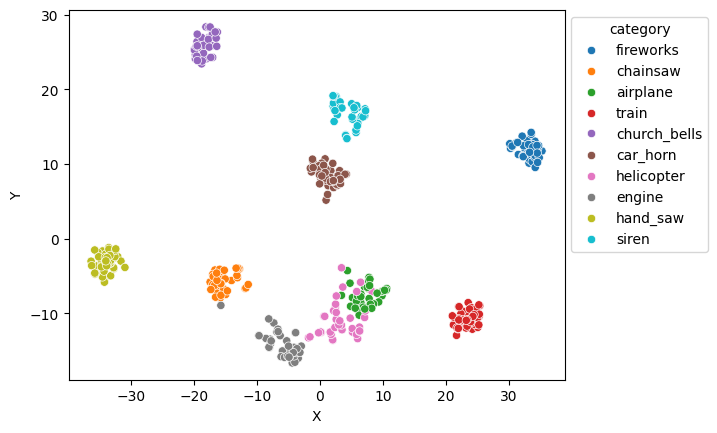

In [22]:
sub_categories = ['helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw', ]
plot_by_sound_categories(sub_categories)

ESC-10 categories ['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain', 'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves']


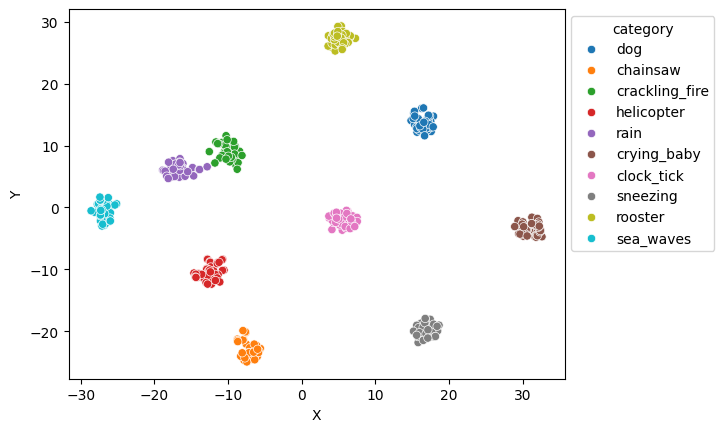

In [23]:
sub_categories = meta[meta.esc10].category.unique()
print('ESC-10 categories', sub_categories.tolist())
plot_by_sound_categories(sub_categories)